In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
import os 

PATH = '.\\..\\dataset\\micro_expressions'
PATH

'.\\..\\dataset\\micro_expressions'

In [4]:
# Conferir o número total de imagens

import pathlib 

train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

print(train_dir)
print(test_dir)

.\..\dataset\micro_expressions\train
.\..\dataset\micro_expressions\test


In [5]:
import pathlib 

train_dir = pathlib.Path(train_dir)
test_dir = pathlib.Path(test_dir)

image_count = len(list(train_dir.glob('*/*.jpg')))
print(image_count)

image_count = len(list(test_dir.glob('*/*.jpg')))
print(image_count)

6938
1700


In [52]:
# Construção e pré-processamento do Dataset a partir das imagens em disco
# Existem 5 pastas para cada uma das classes
# A informação nas pastas não está dividida em conjuntos de treino e validação
# Consultar detalhes na aula anterior e aqui: https://www.tensorflow.org/tutorials/load_data/images

batch_size = 32
IMG_SIZE = (80, 80)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle=True,
  image_size=IMG_SIZE, 
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle=True,
  image_size=IMG_SIZE, 
  batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  validation_split=None, 
  seed=123,
  shuffle=True,
  image_size=IMG_SIZE, 
  batch_size=batch_size)

class_names = train_ds.class_names

train_ds = train_ds.cache().prefetch(1)
val_ds = val_ds.cache().prefetch(1)
test_ds = test_ds.cache().prefetch(1)

normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 6938 files belonging to 7 classes.
Using 5551 files for training.
Found 6938 files belonging to 7 classes.
Using 1387 files for validation.
Found 1700 files belonging to 7 classes.


In [53]:
# Obter alguma informação sobre o dataset

#Cardinalidade 
print('Cardinalidade Treino: ', train_ds.cardinality().numpy())
print('Cardinalidade Validacão: ', val_ds.cardinality().numpy())
print('Cardinalidade Test: ', test_ds.cardinality().numpy())

print('Classes: ', class_names)


# Explicar o valor obtido para a cardinalidade dos conjuntos 


Cardinalidade Treino:  174
Cardinalidade Validacão:  44
Cardinalidade Test:  54
Classes:  ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']


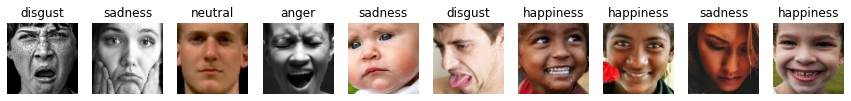

In [43]:
# Visualizar algumas imagens do Dataset
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
    for i in range(10):
        ax = plt.subplot(2, 10, i + 1)
        plt.imshow(images[i].numpy().astype("float32")) #pode ser transformado num array numpy 
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Base model without data augmentation 

In [210]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

inputs = keras.Input(shape=(80, 80, 1))

x = keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(inputs)
x = keras.layers.MaxPooling2D()(x)

x = keras.layers.Conv2D(64, 3, activation='relu',padding='VALID')(x)
x = keras.layers.MaxPooling2D()(x)

x = keras.layers.Conv2D(120, 3, activation='relu',padding='VALID')(x)
x = keras.layers.MaxPooling2D()(x)

x = keras.layers.Flatten()(x)

x = keras.layers.Dense(90, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(60, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(7, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 80, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 38, 38, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 120)       69240     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 120)         0     

In [211]:
# Compilar o modelo
# Utilize o otimizador ADAM com parametrização default e a accuracy como métrica
# Defina a função de loss L que considerar mais apropriada

L = keras.losses.SparseCategoricalCrossentropy()

model.compile(loss=L, optimizer="adam", metrics=["accuracy"])

In [212]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=1
) 

185/185 [==============================] - 3s 11ms/step - loss: 2.6392 - accuracy: 0.2179 - val_loss: 1.8797 - val_accuracy: 0.2673


In [ ]:
# Visualizar os resultados
# Visualização da evolução da accurary e da loss

import pandas as pd 

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot();
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

history_frame.loc[:, [ 'val_accuracy']].max()

In [ ]:
model.evaluate(test_ds)

In [26]:
# Adicionar Data Augmentation aos exemplos de treino para combater overfitting
# Consultar os links seguintes para obter detalhes: https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing
# https://www.tensorflow.org/tutorials/images/data_augmentation

import random

transAug = [
    layers.RandomFlip("horizontal",input_shape=(80, 80, 3)),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode="constant" ,input_shape=(80, 80, 3)),
    layers.RandomZoom(0.2,  fill_mode="constant",input_shape=(80, 80, 3)),
    layers.RandomRotation(0.05, fill_mode="constant",input_shape=(80, 80, 3)),
    layers.RandomContrast(factor=[0.5, 1.3],input_shape=(80, 80, 3)),
    layers.GaussianNoise(0.03)
    ]

def augmentatin(x):
    if random.random() > 0.5 :
        print("one transformation")
        x = random.choice(transAug)(x)
    else:
        print("all transformations")
        x = keras.Sequential(transAug)(x)

    return x


data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",input_shape=(80, 80, 3)),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode="constant"),
    layers.RandomZoom(0.2,  fill_mode="constant"),
    layers.RandomRotation(0.05, fill_mode="constant") ,
    layers.RandomContrast(factor=[0.5, 1.3]),
    layers.GaussianNoise(0.03 )
])

def thefunction(x):
    if random.random() > 0.5 :
        print("one transformation")
        return random.choice(transAug)(x)
    else:
        print("all transformations")
        return data_augmentation(x)

#data_augmentation2 = layers.Lambda(lambda x : thefunction(x))
data_augmentation2 = data_augmentation

class MyAugmentation(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(MyAugmentation, self).__init__(*kwargs)
        self.transformations = [
                                    layers.RandomFlip("horizontal",input_shape=(80, 80, 3)),
                                    layers.RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode="constant"),
                                    layers.RandomZoom(0.2,  fill_mode="constant"),
                                    layers.RandomRotation(0.05, fill_mode="constant"),
                                    layers.RandomContrast(factor=[0.5, 1.3])
                                ]
 
        

    def call(self, indata):
        if random.random() > 0.5 : 
            return random.choice(transAug)(indata)
        else: 
            x = data_augmentation(indata)
            #for l in transAug:
            #    x = l(x)

            return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


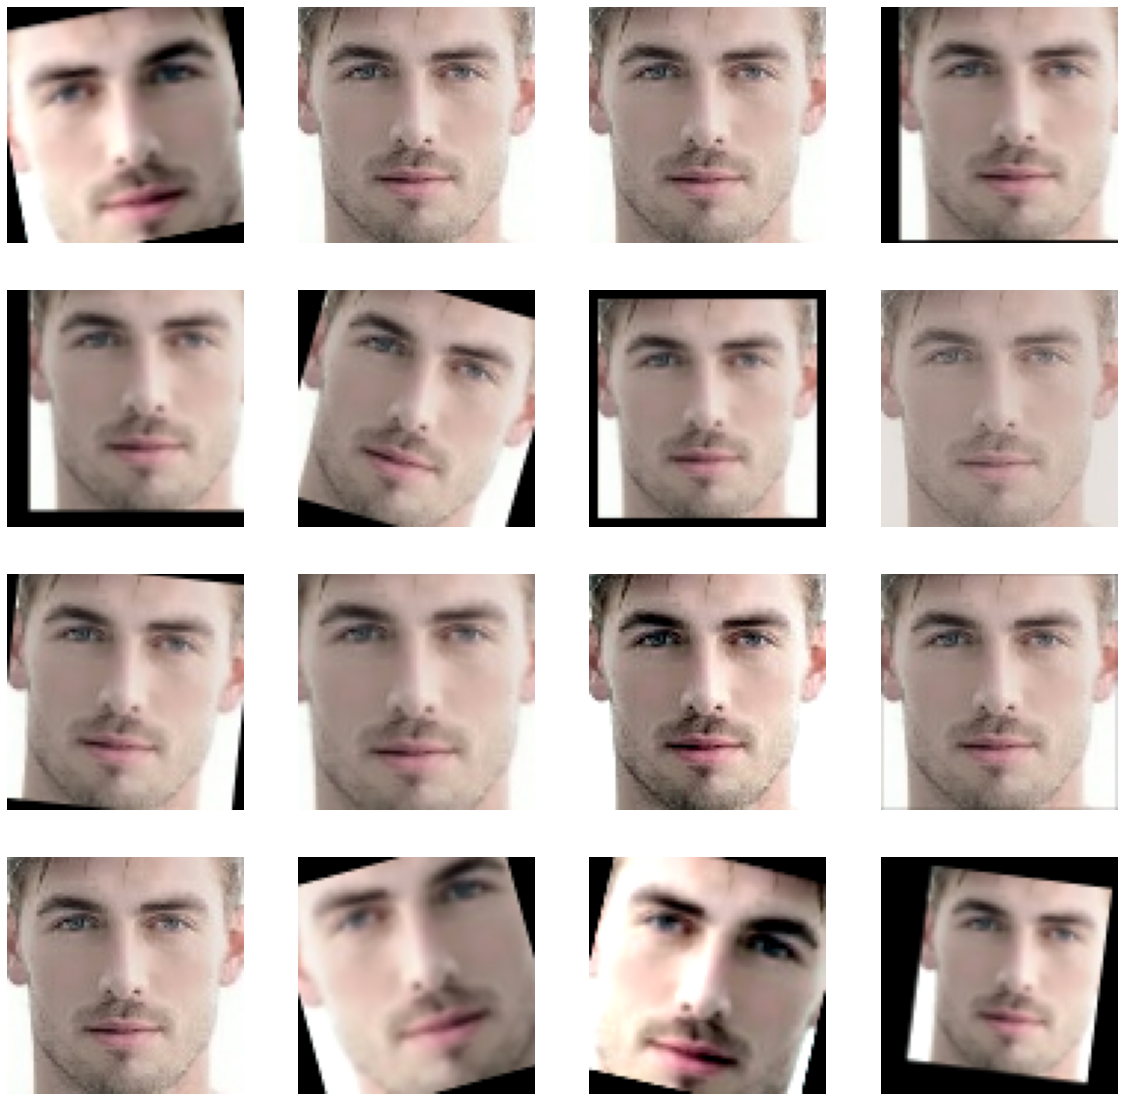

In [44]:
plt.figure(figsize=(20, 20))
for images, _ in train_ds.take(1):
    for i in range(16):
        #augmented_images = data_augmentation(images)
        augmented_images = keras.Sequential([MyAugmentation()])(images)
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(augmented_images[1].numpy().astype("float32"))
        plt.axis("off")


### Base model with data augmentation

In [57]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

inputs = keras.Input(shape=(80, 80, 3))

x = data_augmentation(inputs)

x = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x) 
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x) 
x = layers.MaxPooling2D()(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(64, 3, activation='relu',padding='same')(x) 
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, activation='relu',padding='same')(x) 
x = layers.MaxPooling2D()(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(128, 3, activation='relu',padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, activation='relu',padding='same')(x) 
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, activation='relu',padding='same')(x) 
x = layers.MaxPooling2D()(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(256, 3, activation='relu',padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, 3, activation='relu',padding='same')(x) 
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, 3, activation='relu',padding='same')(x) 
x = layers.BatchNormalization()(x)



x = layers.Flatten()(x) 
x = layers.BatchNormalization()(x)  
x = layers.Dense(120, activation='relu')(x) 
x = layers.Dropout(0.25)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(60, activation='relu')(x) 
x = layers.Dropout(0.25)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(30, activation='relu')(x) 
x = layers.Dropout(0.25)(x)
x = layers.BatchNormalization()(x)

outputs = keras.layers.Dense(7, activation="softmax")(x) 

modelWithAugmentation = keras.Model(inputs=inputs, outputs=outputs)
modelWithAugmentation.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
sequential_134 (Sequential)  (None, 80, 80, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 80, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 80, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 40, 32)        128   

In [ ]:
# Compilar e treinar
from keras.callbacks import ModelCheckpoint
filepath = 'my_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=0, 
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint]

In [68]:


L = keras.losses.SparseCategoricalCrossentropy()

modelWithAugmentation.compile(loss=L, optimizer="adam", metrics=["accuracy"])

history = modelWithAugmentation.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50,
  callbacks=callbacks
)


Epoch 1/50
174/174 [==============================] - 7s 30ms/step - loss: 0.1628 - accuracy: 0.9517 - val_loss: 0.8049 - val_accuracy: 0.8046
Epoch 2/50
174/174 [==============================] - 5s 30ms/step - loss: 0.1573 - accuracy: 0.9508 - val_loss: 0.8375 - val_accuracy: 0.8017
Epoch 3/50
174/174 [==============================] - 5s 29ms/step - loss: 0.1438 - accuracy: 0.9557 - val_loss: 0.8132 - val_accuracy: 0.8075
Epoch 4/50
174/174 [==============================] - 5s 30ms/step - loss: 0.1476 - accuracy: 0.9539 - val_loss: 0.6804 - val_accuracy: 0.8226
Epoch 5/50
174/174 [==============================] - 5s 30ms/step - loss: 0.1574 - accuracy: 0.9490 - val_loss: 0.7658 - val_accuracy: 0.8111
Epoch 6/50
174/174 [==============================] - 5s 30ms/step - loss: 0.1498 - accuracy: 0.9528 - val_loss: 0.7832 - val_accuracy: 0.8169
Epoch 7/50
174/174 [==============================] - 5s 30ms/step - loss: 0.1493 - accuracy: 0.9559 - val_loss: 0.7776 - val_accuracy: 0.8183

val_accuracy    0.839942
dtype: float64

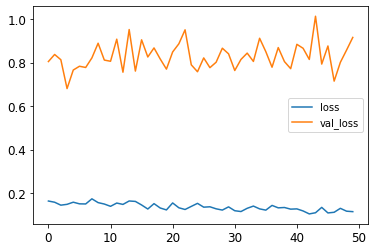

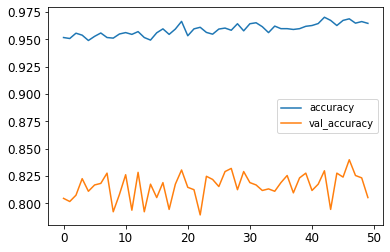

In [69]:
import pandas as pd 

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

history_frame.loc[:, [ 'val_accuracy']].max()

In [71]:
from keras.models import load_model
model = load_model(filepath)
model.evaluate(test_ds)

54/54 [==============================] - 1s 12ms/step - loss: 0.7994 - accuracy: 0.8418


[0.799392580986023, 0.8417646884918213]